<a href="https://colab.research.google.com/github/kaho1156/banking-txn-monitoring/blob/main/transactionMonitor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.7 MB/s eta 0:00:00


In [14]:
import pandas as pd
import sqlite3
import random
from faker import Faker
from datetime import datetime, timedelta

# ==========================================
# 1. DATA INGESTION (入數)
# ==========================================
class AMLDataGenerator:
    def __init__(self, num_customers=300):
        self.fake = Faker()
        self.num_customers = num_customers
        self.exchange_rates = {"AUD": 1.0, "USD": 1.5, "HKD": 0.2}

    def generate_static_data(self):
        cust_list = []
        start_date = datetime.now() - timedelta(days=365*5)
        for i in range(1, self.num_customers + 1):
            cust_list.append({
                "CIN": f"C{i:04d}",
                "Cust_Name": self.fake.name(),
                "Cust_Tier": random.choice(["GOLD", "SILVER", "VIP"]),
                "Cust_Sin_Dt": (start_date + timedelta(days=random.randint(0, 365*5))).date()
            })
        return pd.DataFrame(cust_list)

    def generate_dynamic_data(self, df_cust):
        txn_list = []
        txn_types = ["CASH", "WIRE", "ONLINE", "CARD", "ATM", "NON FACE TO FACE"]
        merchants = ["JPMorgan", "Amazon", "Coles", "Shell", "Apple Store", "PayPal"]

        for cin in df_cust['CIN']:
            for _ in range(random.randint(5, 50)):
                cur = random.choice(["HKD", "USD", "AUD"])
                amount = round(random.uniform(10, 20000), 2)
                if random.random() < 0.05: amount *= 10 # 模擬大額異常

                txn_list.append({
                    "Txn_Date": (datetime.now() - timedelta(days=random.randint(0, 730))).strftime("%d/%m/%Y %H:%M:%S"),
                    "CIN": cin,
                    "Txn_Cur": cur,
                    "Txn_Amt": amount,
                    "Nf2f": random.choice(["Y", "N"]),
                    "Txn_Type": random.choice(txn_types),
                    "Counterparty": random.choice(merchants) if random.choice([True, False]) else None
                })
        return pd.DataFrame(txn_list)

# ==========================================
# 2. PROCESSING (處理)
# ==========================================
def process_aml_data(df_cust, df_txn, exchange_rates):
    # 使用 .copy() 避免 SettingWithCopyWarning
    df_txn = df_txn.copy()
    df_cust = df_cust.copy()

    df_txn['Txn_Date'] = pd.to_datetime(df_txn['Txn_Date'], dayfirst=True)
    df_cust['Cust_Sin_Dt'] = pd.to_datetime(df_cust['Cust_Sin_Dt'])

    # 計算 AUD 價值
    df_txn['Txn_Amt_AUD'] = df_txn.apply(lambda x: round(x['Txn_Amt'] * exchange_rates[x['Txn_Cur']], 2), axis=1)

    return df_cust, df_txn

# ==========================================
# 3. ANALYSIS & MONITORING (SQL 輸出)
# ==========================================
def run_single_monitoring_scenario(conn, scenario_name):
    scenarios = {
        "High-Risk New Customers": """
            SELECT T.*, C.Cust_Sin_Dt
            FROM txn_data T
            JOIN cust_data C ON T.CIN = C.CIN
            WHERE T.Txn_Date >= C.Cust_Sin_Dt
              AND julianday(T.Txn_Date) - julianday(C.Cust_Sin_Dt) <= 30
              AND T.Txn_Amt_AUD > 10000;
        """,
        "Potential Smurfing": """
            SELECT CIN, COUNT(*) as cnt, SUM(Txn_Amt_AUD) as total_vol
            FROM txn_data
            WHERE Txn_Type = 'CASH'
            GROUP BY CIN, date(Txn_Date)
            HAVING cnt >= 3 AND total_vol BETWEEN 8000 AND 10000;
        """,
        "Large Cash Txn Summary": """
            SELECT C.Cust_Tier, COUNT(T.Txn_Cur) as Txn_Count, SUM(T.Txn_Amt_AUD) as Total_AUD
            FROM txn_data T
            JOIN cust_data C ON T.CIN = C.CIN
            WHERE T.Txn_Type = 'CASH'
            GROUP BY C.Cust_Tier
            ORDER BY Total_AUD DESC;
        """
    }

    if scenario_name in scenarios:
        print(f"\n🚀 [ALERT] Executing Scenario: {scenario_name}")
        query = scenarios[scenario_name]
        return pd.read_sql(query, conn)
    else:
        print(f"❌ Error: Scenario '{scenario_name}' not found.")
        return None

# ==========================================
# 4. 執行系統 (Main Execution)
# ==========================================
# 初始化數據
generator = AMLDataGenerator()
df_raw_cust = generator.generate_static_data()
df_raw_txn = generator.generate_dynamic_data(df_raw_cust)

# 清洗數據
df_cust, df_txn = process_aml_data(df_raw_cust, df_raw_txn, generator.exchange_rates)

# 建立並寫入資料庫
# 使用 context manager (with) 確保連線正確關閉係專業做法
with sqlite3.connect(":memory:") as conn:
    df_cust.to_sql("cust_data", conn, index=False)
    df_txn.to_sql("txn_data", conn, index=False)

    # 修正：傳入正確嘅函數名同埋資料庫連線參數
    result_df = run_single_monitoring_scenario(conn, "Large Cash Txn Summary")

    # 顯示結果
    if result_df is not None:
        print(result_df.head())

        # 額外 Touch up：自動匯出 CSV
        result_df.to_csv("aml_alert_report.csv", index=False)
        print("\n✅ Report exported to aml_alert_report.csv")


🚀 [ALERT] Executing Scenario: Large Cash Txn Summary
  Cust_Tier  Txn_Count   Total_AUD
0      GOLD        472  7415598.08
1    SILVER        536  7142246.20
2       VIP        424  5109247.12

✅ Report exported to aml_alert_report.csv


In [5]:
##df_txn.to_csv("Txn.csv")

Step 1: Ingesting Data...
Step 2: Processing ETL...
Step 3: Running Monitoring Scenarios...

[ALERT] New Customer High-Risk Activity (Total: 56)
              Txn_Date    CIN Txn_Cur   Txn_Amt Txn_Type Nf2f  Txn_Amt_AUD  \
0  2025-05-16 08:06:28  C0011     AUD  10264.61     CARD    Y     10264.61   
1  2025-04-18 08:06:28  C0015     USD  12332.17      ATM    N     18498.26   
2  2025-04-04 08:06:28  C0017     AUD  16289.64      ATM    N     16289.64   
3  2024-01-08 08:06:28  C0041     AUD  16524.49     CARD    N     16524.49   
4  2024-05-26 08:06:28  C0068     AUD  13286.13     CARD    N     13286.13   

           Cust_Sin_Dt  
0  2025-05-11 00:00:00  
1  2025-04-02 00:00:00  
2  2025-03-19 00:00:00  
3  2024-01-07 00:00:00  
4  2024-05-01 00:00:00  

[ALERT] Potential Structuring (Smurfing) (Total: 0)
Empty DataFrame
Columns: [CIN, cnt, total_vol]
Index: []

[ALERT] Cash Volume Summary by Tier (Total: 3)
  Cust_Tier  Txn_Count   Total_AUD
0      GOLD        521  5842360.43
1    SIL

/tmp/ipython-input-1748508876.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Cust_Tier', y='Total_AUD', data=summary_df, palette='magma')


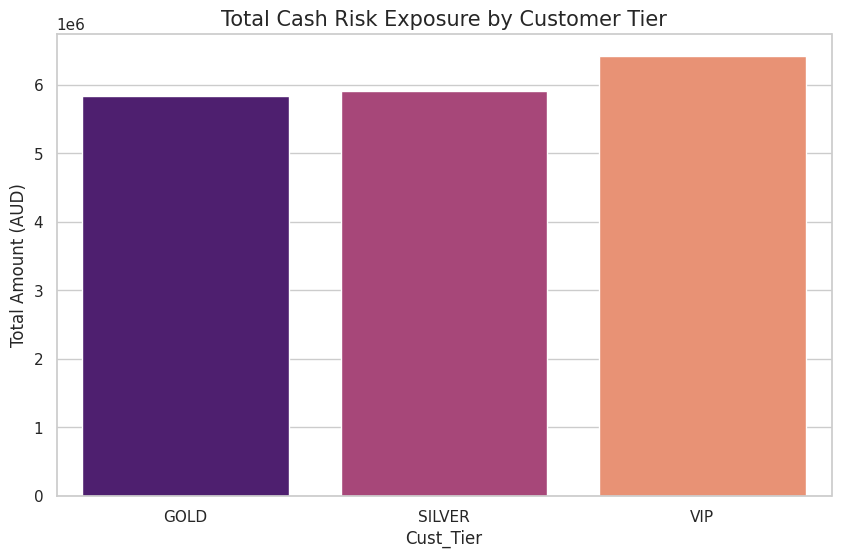

In [15]:
import pandas as pd
import sqlite3
import random
import matplotlib.pyplot as plt
import seaborn as sns
from faker import Faker
from datetime import datetime, timedelta

"""
AML Transaction Monitoring & Surveillance System (PoC)
Author: Moses Wong
Description: An end-to-end pipeline simulating banking data ingestion,
             ETL processing, and SQL-based rule monitoring for AML compliance.
"""

class AMLSystem:
    def __init__(self, num_customers=300):
        self.fake = Faker()
        self.num_customers = num_customers
        self.exchange_rates = {"AUD": 1.0, "USD": 1.5, "HKD": 0.2}
        self.conn = sqlite3.connect(":memory:") # Using in-memory DB for demonstration

    def generate_data(self):
        """Phase 1: Data Ingestion - Synthesizing Customer and Transaction Data"""
        # Generate Static Customer Data
        cust_list = []
        start_date = datetime.now() - timedelta(days=365*5)
        for i in range(1, self.num_customers + 1):
            cust_list.append({
                "CIN": f"C{i:04d}",
                "Cust_Name": self.fake.name(),
                "Cust_Tier": random.choice(["GOLD", "SILVER", "VIP"]),
                "Cust_Sin_Dt": (start_date + timedelta(days=random.randint(0, 365*5))).date()
            })
        df_cust = pd.DataFrame(cust_list)

        # Generate Dynamic Transaction Data
        txn_list = []
        txn_types = ["CASH", "WIRE", "ONLINE", "CARD", "ATM", "NON FACE TO FACE"]
        for cin in df_cust['CIN']:
            for _ in range(random.randint(5, 50)):
                cur = random.choice(["HKD", "USD", "AUD"])
                amt = round(random.uniform(10, 20000), 2)
                if random.random() < 0.05: amt *= 10 # Simulate Outliers

                txn_list.append({
                    "Txn_Date": (datetime.now() - timedelta(days=random.randint(0, 730))).strftime("%d/%m/%Y %H:%M:%S"),
                    "CIN": cin,
                    "Txn_Cur": cur,
                    "Txn_Amt": amt,
                    "Txn_Type": random.choice(txn_types),
                    "Nf2f": random.choice(["Y", "N"])
                })
        df_txn = pd.DataFrame(txn_list)
        return df_cust, df_txn

    def process_data(self, df_cust, df_txn):
        """Phase 2: ETL & Data Transformation"""
        df_txn = df_txn.copy()
        # Standardize Timeframes
        df_txn['Txn_Date'] = pd.to_datetime(df_txn['Txn_Date'], dayfirst=True)
        df_cust['Cust_Sin_Dt'] = pd.to_datetime(df_cust['Cust_Sin_Dt'])

        # Currency Conversion to Base (AUD)
        df_txn['Txn_Amt_AUD'] = df_txn.apply(
            lambda x: round(x['Txn_Amt'] * self.exchange_rates[x['Txn_Cur']], 2), axis=1
        )

        # Load into SQLite for Monitoring
        df_cust.to_sql("cust_data", self.conn, index=False, if_exists="replace")
        df_txn.to_sql("txn_data", self.conn, index=False, if_exists="replace")

    def run_scenarios(self):
        """Phase 3: Surveillance Scenarios (SQL-based Monitoring)"""
        scenarios = {
            "New Customer High-Risk Activity": """
                SELECT T.*, C.Cust_Sin_Dt
                FROM txn_data T
                JOIN cust_data C ON T.CIN = C.CIN
                WHERE T.Txn_Date >= C.Cust_Sin_Dt
                  AND julianday(T.Txn_Date) - julianday(C.Cust_Sin_Dt) <= 30
                  AND T.Txn_Amt_AUD > 10000;
            """,
            "Potential Structuring (Smurfing)": """
                SELECT CIN, COUNT(*) as cnt, SUM(Txn_Amt_AUD) as total_vol
                FROM txn_data
                WHERE Txn_Type = 'CASH'
                GROUP BY CIN, date(Txn_Date)
                HAVING cnt >= 3 AND total_vol BETWEEN 8000 AND 10000;
            """,
            "Cash Volume Summary by Tier": """
                SELECT C.Cust_Tier, COUNT(T.Txn_Cur) as Txn_Count, SUM(T.Txn_Amt_AUD) as Total_AUD
                FROM txn_data T
                JOIN cust_data C ON T.CIN = C.CIN
                WHERE T.Txn_Type = 'CASH'
                GROUP BY C.Cust_Tier;
            """
        }

        results = {}
        for name, query in scenarios.items():
            results[name] = pd.read_sql(query, self.conn)
        return results

    def visualize(self, summary_df):
        """Phase 4: Data Visualization for Stakeholders"""
        sns.set_theme(style="whitegrid")
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x='Cust_Tier', y='Total_AUD', data=summary_df, palette='magma')
        plt.title('Total Cash Risk Exposure by Customer Tier', fontsize=15)
        plt.ylabel('Total Amount (AUD)')
        plt.savefig("aml_risk_summary.png")
        plt.show()

# --- Execution ---
if __name__ == "__main__":
    sys = AMLSystem()
    print("Step 1: Ingesting Data...")
    raw_cust, raw_txn = sys.generate_data()

    print("Step 2: Processing ETL...")
    sys.process_data(raw_cust, raw_txn)

    print("Step 3: Running Monitoring Scenarios...")
    alerts = sys.run_scenarios()

    for alert_name, df in alerts.items():
        print(f"\n[ALERT] {alert_name} (Total: {len(df)})")
        print(df.head())

    print("\nStep 4: Generating Visualization...")
    sys.visualize(alerts["Cash Volume Summary by Tier"])